In [144]:
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import seaborn as sns
from darts.models import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
from tasks_support_system_ai.utils import get_correct_data_path
from tasks_support_system_ai.readers import (
    ts_read_daily_tickets,
    read_ts_tree,
    get_map_parent_to_children_queues,
)

In [145]:
df = ts_read_daily_tickets(get_correct_data_path("tickets_daily/tickets_daily.csv"))
tree = read_ts_tree(get_correct_data_path("dataset_tickets_timeseries/tree_queue.tsv"))

In [146]:
df

,queueId,date,new_tickets
0,1,2017-01-01,15
1,1,2017-01-02,26
2,1,2017-01-03,25
3,1,2017-01-04,29
4,1,2017-01-05,26
...,...,...,...
418322,9,2020-08-30,1
418323,9,2020-09-13,1
418324,9,2020-09-16,1
418325,9,2020-09-17,1


# Проверка аномалий в данных

In [147]:
df.describe()

,queueId,date,new_tickets
count,418327.000000,418327,418327.000000
mean,20450.068822,2019-03-01 08:31:49.778714368,36.909838
min,1.000000,2017-01-01 00:00:00,1.000000
25%,2017.000000,2018-04-20 00:00:00,5.000000
50%,2752.000000,2019-04-25 00:00:00,14.000000
75%,4162.000000,2020-02-04 00:00:00,37.000000
max,101359.000000,2020-09-30 00:00:00,22072.000000
std,37997.424512,NaN,89.480679


In [148]:
df.isnull().sum()
#Нулевых значений нет

queueId        0
date           0
new_tickets    0
dtype: int64

In [149]:
print(np.isnan(df).sum())
#Пропусков нет

queueId        0
date           0
new_tickets    0
dtype: int64


In [150]:
grouped_df = df.groupby('queueId')['new_tickets'].agg(['count']).reset_index()
grouped_df
#Сколько всего тикетов в очередях

,queueId,count
0,1,1369
1,7,1368
2,9,222
3,10,1369
4,13,1368
...,...,...
823,101349,7
824,101350,8
825,101351,7
826,101352,8


In [151]:
def detect_outliers(group):
    Q1 = group['new_tickets'].quantile(0.25)
    Q3 = group['new_tickets'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['new_tickets'] < lower_bound) | (group['new_tickets'] > upper_bound)]

outliers = df.groupby('queueId').apply(detect_outliers).reset_index(drop=True)
print(outliers)

       queueId       date  new_tickets
0            1 2017-11-28          323
1            1 2018-01-12          217
2            1 2018-10-10          241
3            1 2018-12-20          357
4            1 2019-07-26          229
...        ...        ...          ...
17233   101343 2020-09-28            3
17234   101343 2020-09-30           13
17235   101350 2020-09-23           77
17236   101350 2020-09-29          278
17237   101352 2020-09-23           11

[17238 rows x 3 columns]


C:\Users\SUBRU\AppData\Local\Temp\ipykernel_15748\1391790551.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers = df.groupby('queueId').apply(detect_outliers).reset_index(drop=True)


In [152]:
df.duplicated().sum()
#Дубликатов нет

0

# Тренд и сезонность в данных

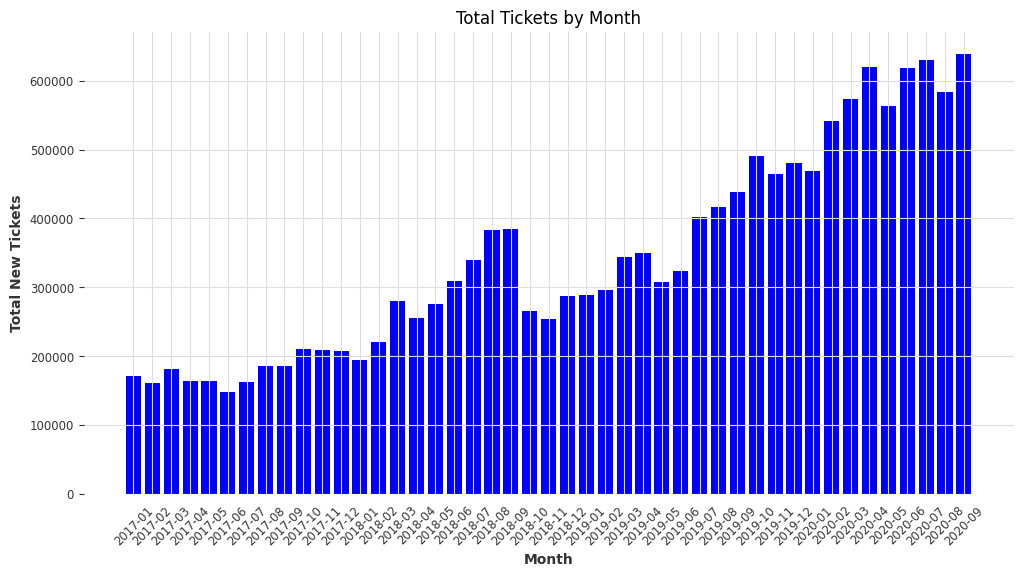

In [153]:

df['month'] = df['date'].dt.to_period('M')

monthly_tickets = df.groupby('month')['new_tickets'].sum().reset_index()

# Визуализация
plt.figure(figsize=(12, 6))
plt.bar(monthly_tickets['month'].astype(str), monthly_tickets['new_tickets'], color='blue')
plt.title('Total Tickets by Month')
plt.xlabel('Month')
plt.ylabel('Total New Tickets')
plt.xticks(rotation=45)
plt.show()


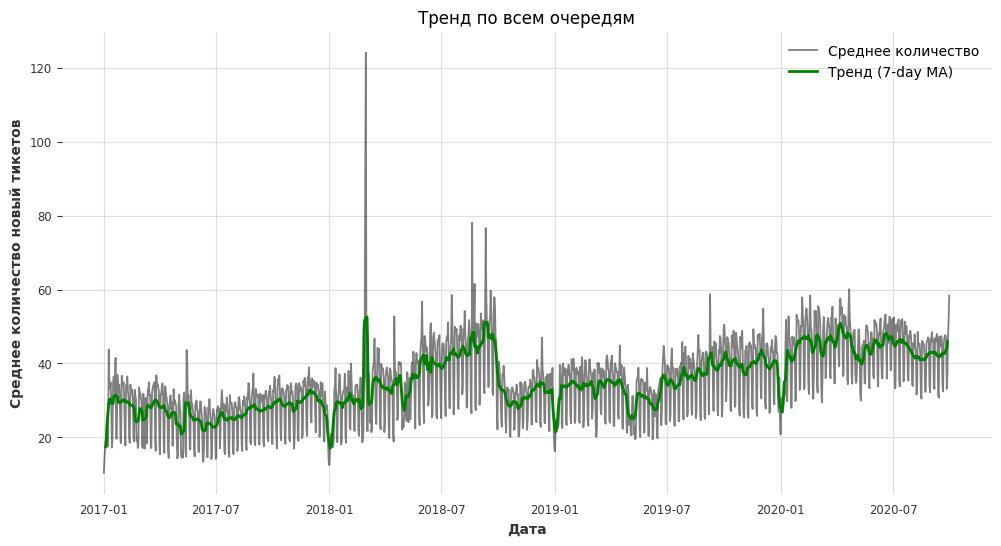

In [154]:
aggregated_df = df.groupby('date')['new_tickets'].mean().reset_index()
aggregated_df['trend'] = aggregated_df['new_tickets'].rolling(window=7, center=True).mean()

# Визуализация общего тренда
plt.figure(figsize=(12, 6))
plt.plot(aggregated_df['date'], aggregated_df['new_tickets'], label='Среднее количество', alpha=0.5)
plt.plot(aggregated_df['date'], aggregated_df['trend'], label='Тренд (7-day MA)', color='green', linewidth=2)
plt.title('Тренд по всем очередям')
plt.xlabel('Дата')
plt.ylabel('Среднее количество новый тикетов')
plt.legend()
plt.show()

C:\Users\SUBRU\AppData\Local\Temp\ipykernel_15748\485578978.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(index='day_of_week', columns='month', values='new_tickets', aggfunc='mean')


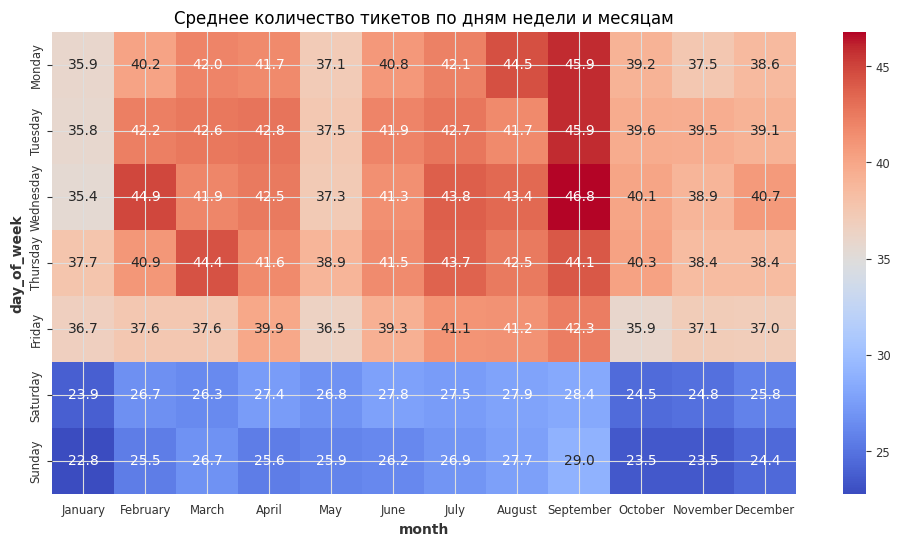

In [155]:
df['day_of_week'] = df['date'].dt.day_name()
df['month'] = df['date'].dt.month_name()

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)


heatmap_data = df.pivot_table(index='day_of_week', columns='month', values='new_tickets', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Среднее количество тикетов по дням недели и месяцам')
plt.show()


In [156]:
def analyze_queues_stl(df, top_queues):
    for queue_id in top_queues:
        if queue_id in df['queueId'].values:
            queue_data = df[df['queueId'] == queue_id].set_index('date')['new_tickets']

        
            stl = STL(queue_data, seasonal=13) 
            result = stl.fit()

     
            plt.figure(figsize=(12, 12))

        # График оригинального временного ряда
            plt.subplot(3, 1, 1)
            plt.plot(queue_data, label='График временного ряда', color='green')
            plt.title(f'График временного ряда для очереди {queue_id}')
            plt.xlabel('Date')
            plt.ylabel('Number of New Tickets')
            plt.legend()

        # График тренда
            plt.subplot(3, 1, 2)
            plt.plot(result.trend, label='Тренд', color='orange')
            plt.title('Тренд')
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.legend()

        # График сезонности
            plt.subplot(3, 1, 3)
            plt.plot(result.seasonal, label='Сезонность', color='blue')
            plt.title('Сезонность')
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.legend()

            plt.tight_layout()
            plt.show()


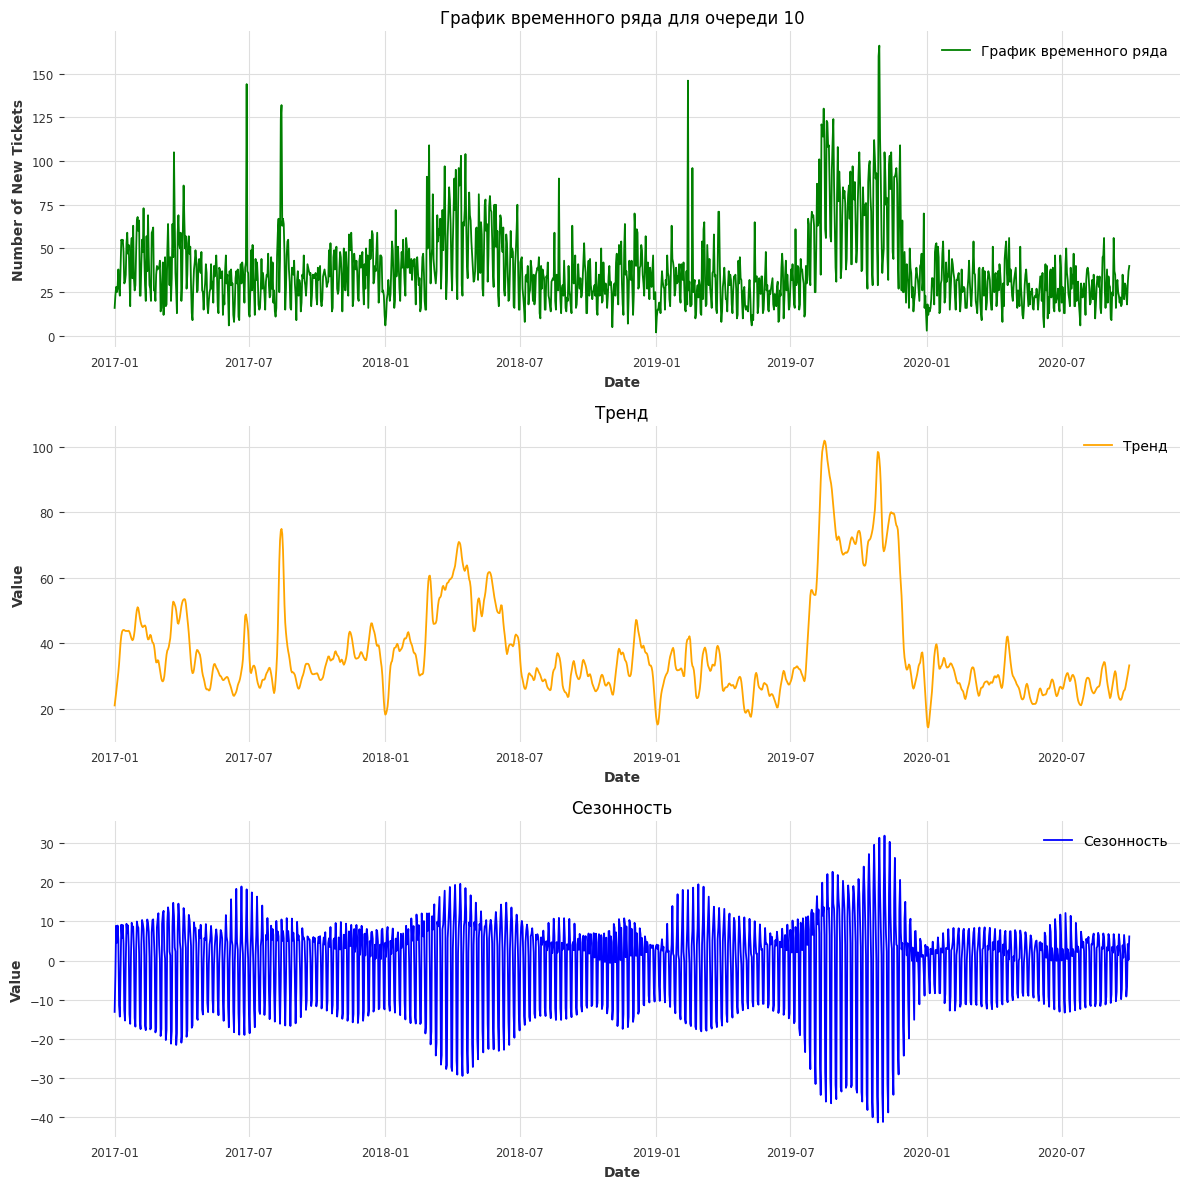

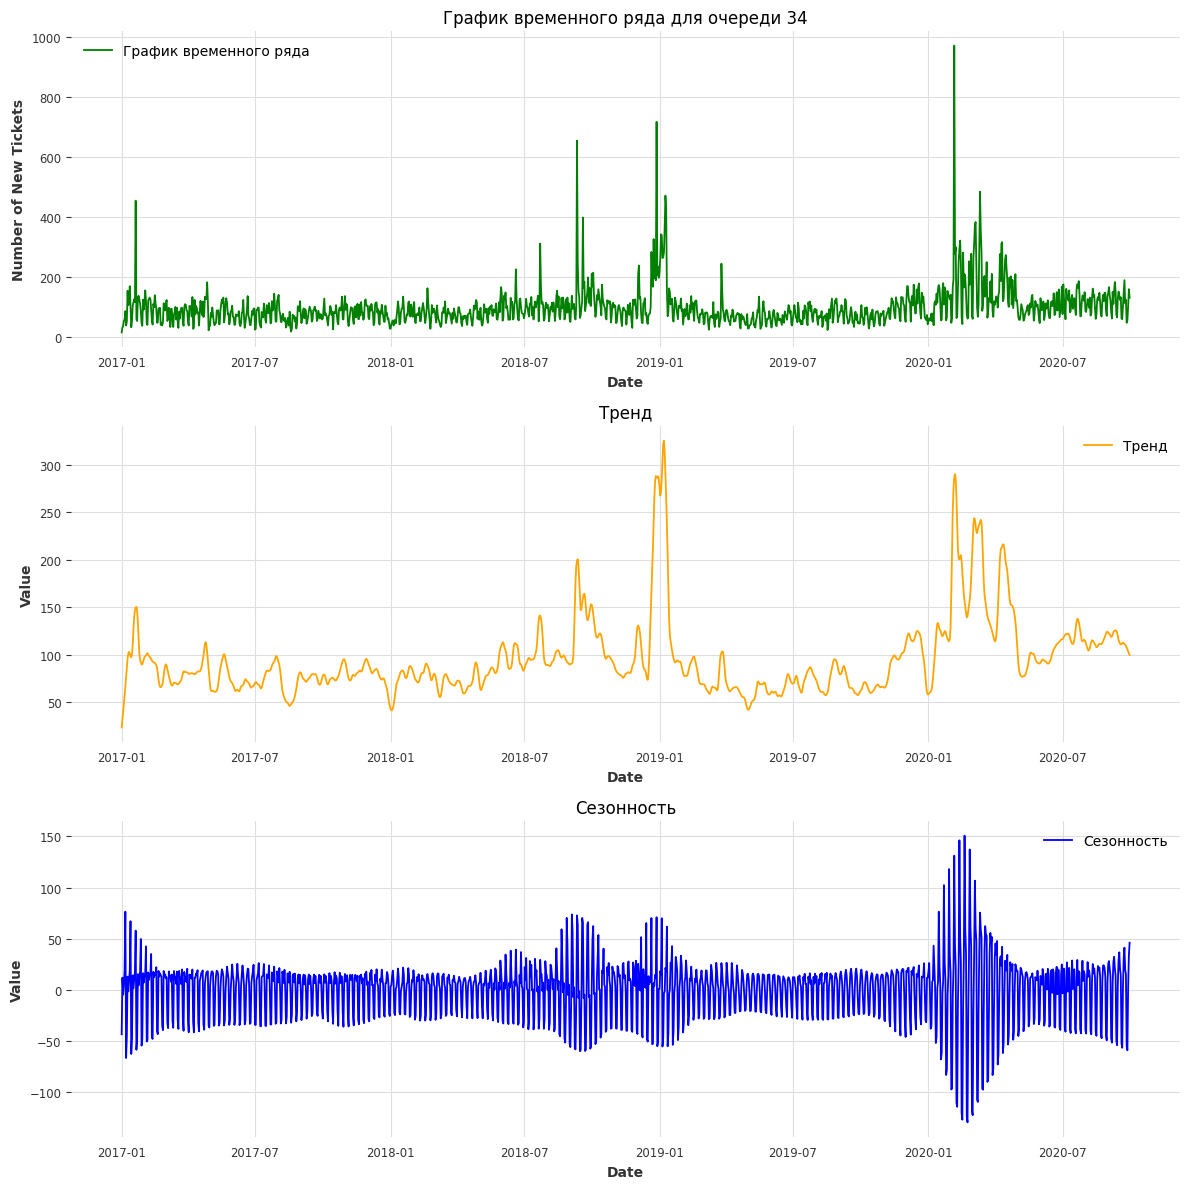

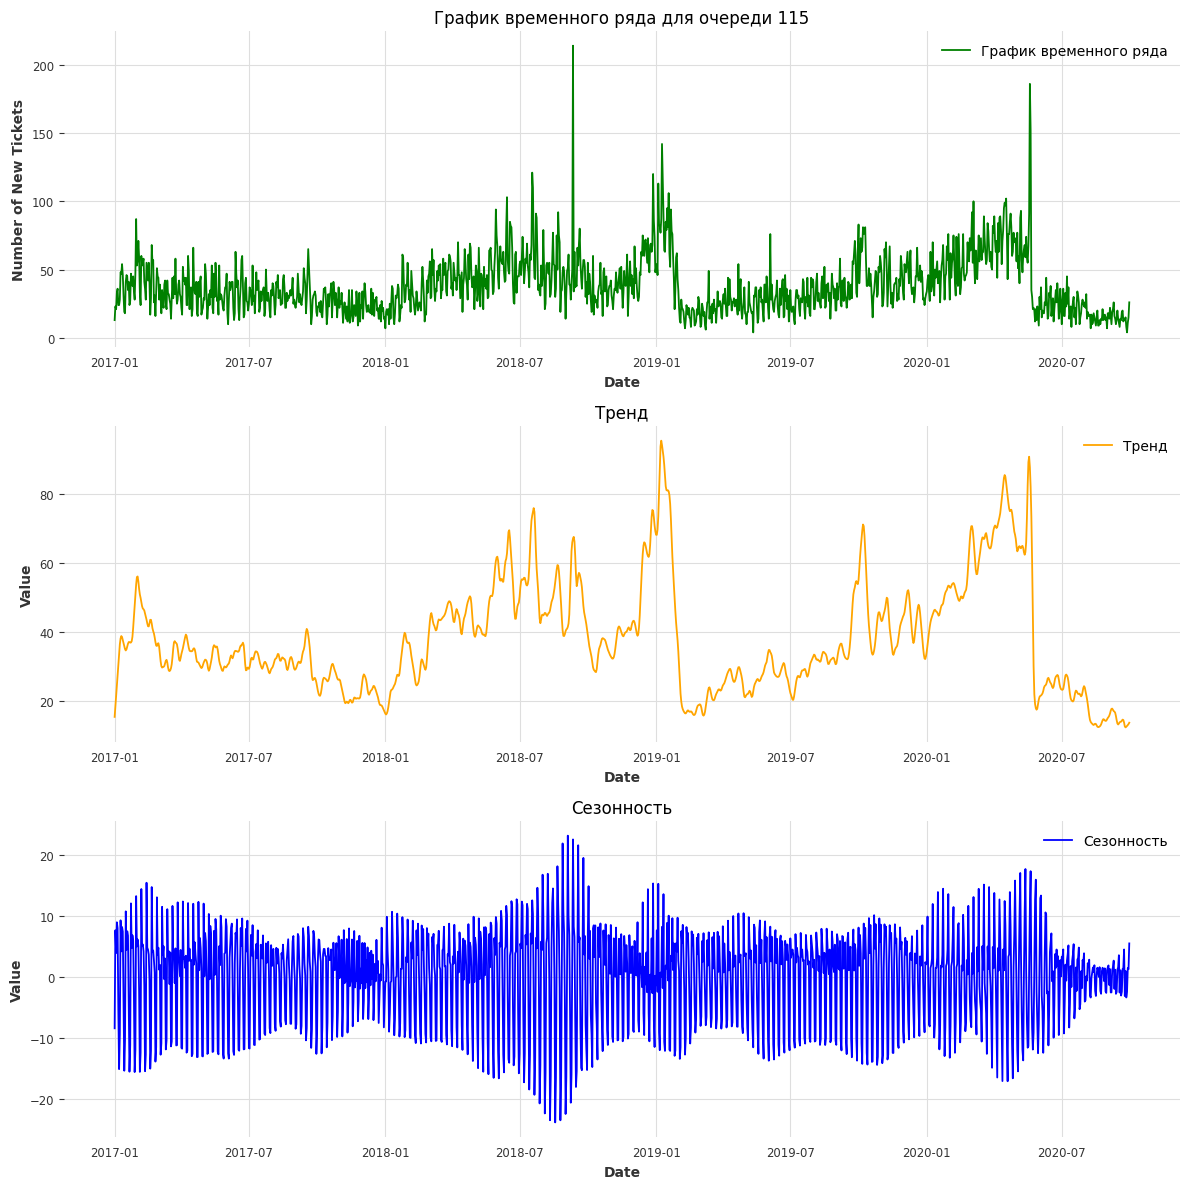

None


In [157]:
select_queue = [10, 34, 115]
print(analyze_queues_stl(df, select_queue))

# Аналитика в разрезе очередей

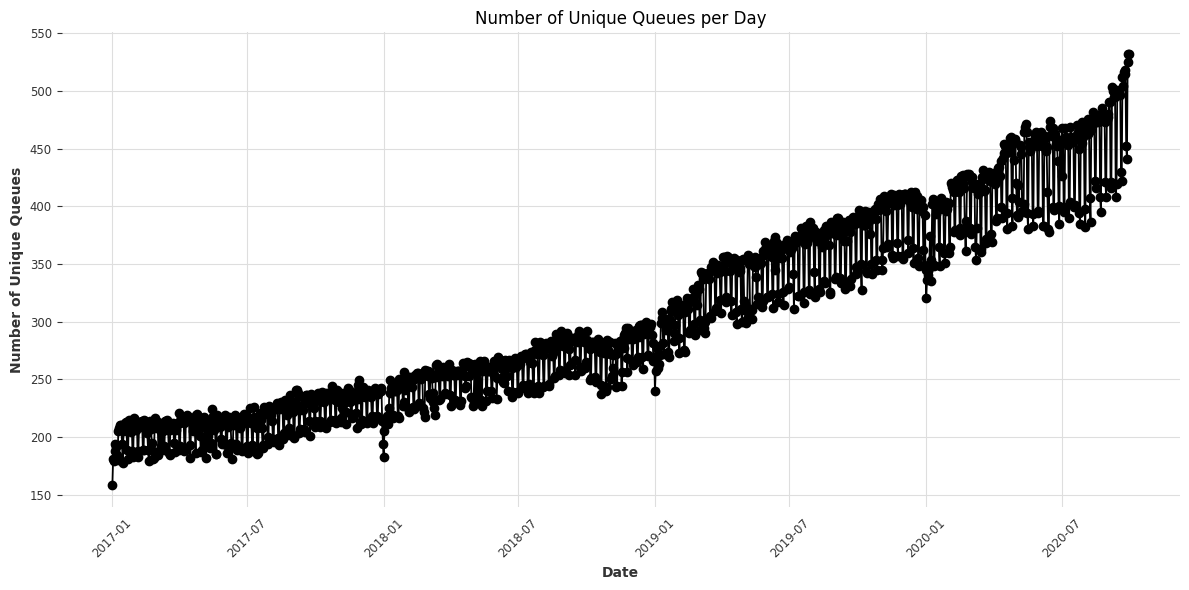

In [158]:
unique_queues = df.groupby("date")["queueId"].nunique().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(unique_queues["date"], unique_queues["queueId"], marker="o")
plt.title("Number of Unique Queues per Day")
plt.xlabel("Date")
plt.ylabel("Number of Unique Queues")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [159]:
queue_to_all_children = get_map_parent_to_children_queues(tree)
size_queues = {}
for queue, children in queue_to_all_children.items():
    size_queues[queue] = df[df["queueId"].isin(children)].shape[0]
n = 10
top_queues = dict(sorted(size_queues.items(), key=lambda item: -item[1])[:n]).keys()
print(top_queues)

dict_keys([742, 1871, 115, 4447, 2641, 2002, 10, 4412, 34, 2610])


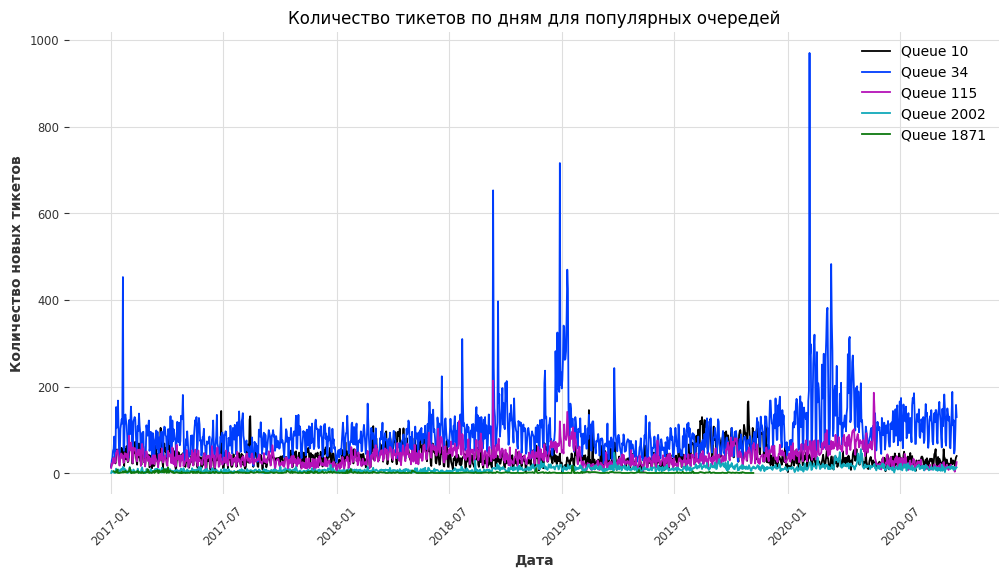

In [160]:

selected_queues = df[df['queueId'].isin(top_queues)]

daily_tickets = selected_queues.groupby(['date', 'queueId'])['new_tickets'].sum().reset_index()

plt.figure(figsize=(12, 6))
for queue_id in daily_tickets['queueId'].unique():
    plt.plot(daily_tickets[daily_tickets['queueId'] == queue_id]['date'],
             daily_tickets[daily_tickets['queueId'] == queue_id]['new_tickets'],
             label=f'Queue {queue_id}')

plt.title('Количество тикетов по дням для популярных очередей')
plt.xlabel('Дата')
plt.ylabel('Количество новых тикетов')
plt.legend()
plt.xticks(rotation=45)
plt.show()


# Проверим сезонность, автокорреляцию, лаги с помощью тестов ACF, PACF, ADF

In [161]:
def analyze_queues(df, top_queues):
    adf_results = {}

    for queue_id in top_queues:
   
        if queue_id in df['queueId'].values:
            
            queue_data = df[df['queueId'] == queue_id].set_index('date')['new_tickets']

            #ADF
            adf_result = adfuller(queue_data)
            adf_results[queue_id] = {
                'ADF Statistic': adf_result[0],
                'p-value': adf_result[1],
                'Critical Values': adf_result[4]
            }

            
            plt.figure(figsize=(12, 6))
            
            # ACF
            plt.subplot(1, 2, 1)
            plot_acf(queue_data, lags=30, ax=plt.gca(), title=f'ACF for Queue {queue_id}', zero=False)

            # PACF
            plt.subplot(1, 2, 2)
            plot_pacf(queue_data, lags=30, ax=plt.gca(), title=f'PACF for Queue {queue_id}', zero=False)

            plt.tight_layout()
            plt.show()
        else:
            print(f'Queue ID {queue_id} does not exist in the dataset.')

    for queue_id, results in adf_results.items():
        print(f'Queue ID: {queue_id}')
        print(f"  ADF Statistic: {results['ADF Statistic']:.4f}")
        print(f"  p-value: {results['p-value']:.4f}")
        print(f"  Critical Values:")
        for key, value in results['Critical Values'].items():
            print(f"    {key}: {value:.4f}")
        print()

    return adf_results


Queue ID 742 does not exist in the dataset.


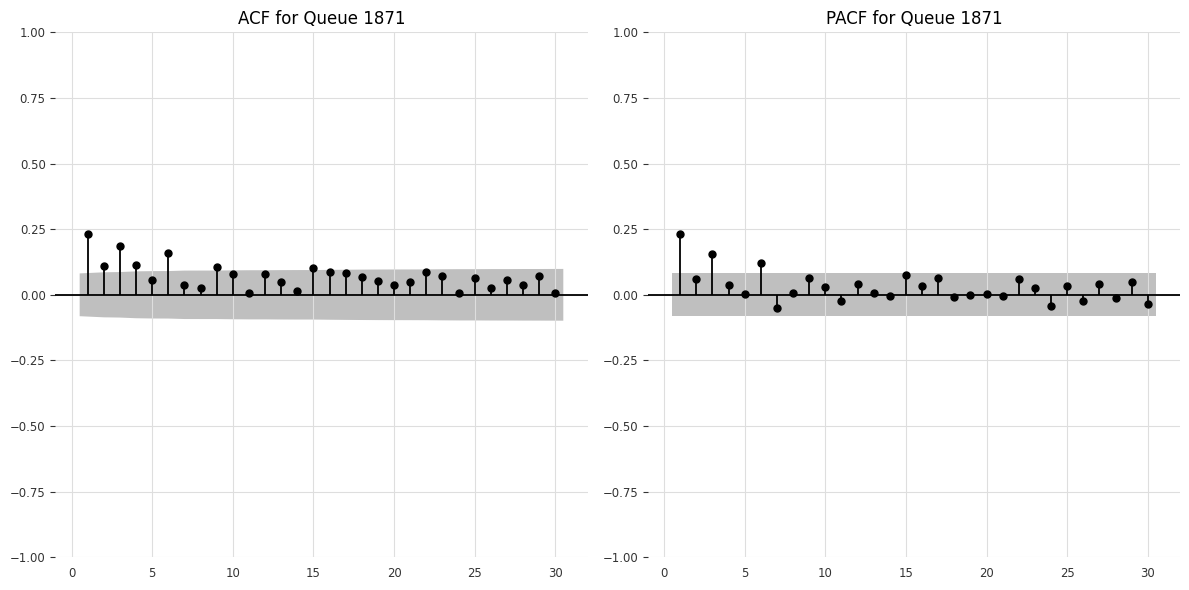

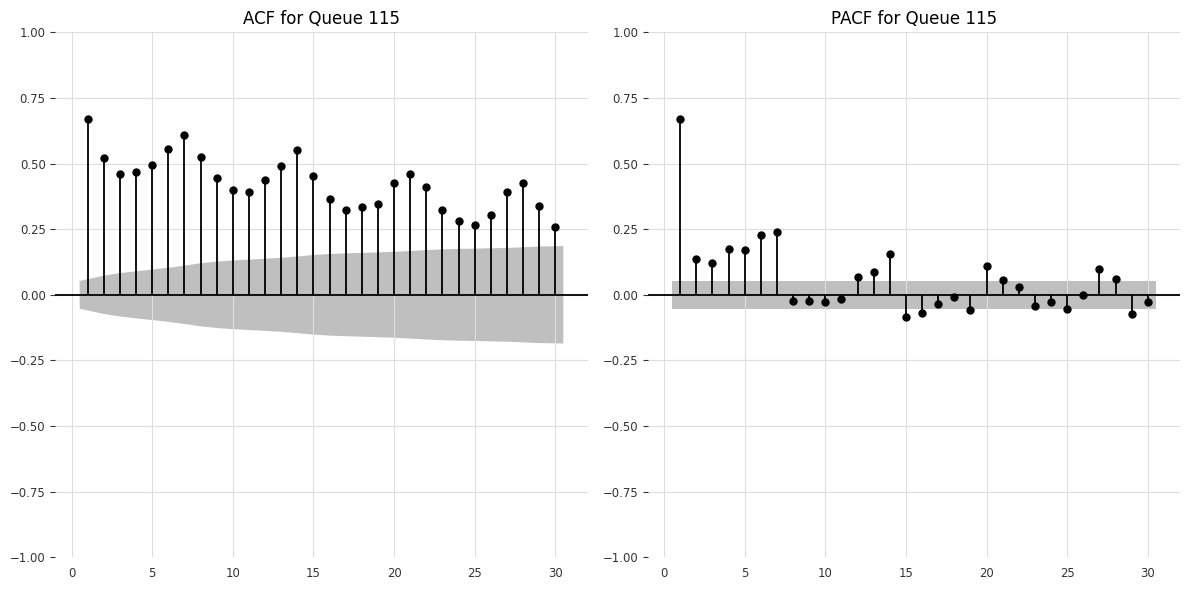

Queue ID 4447 does not exist in the dataset.
Queue ID 2641 does not exist in the dataset.


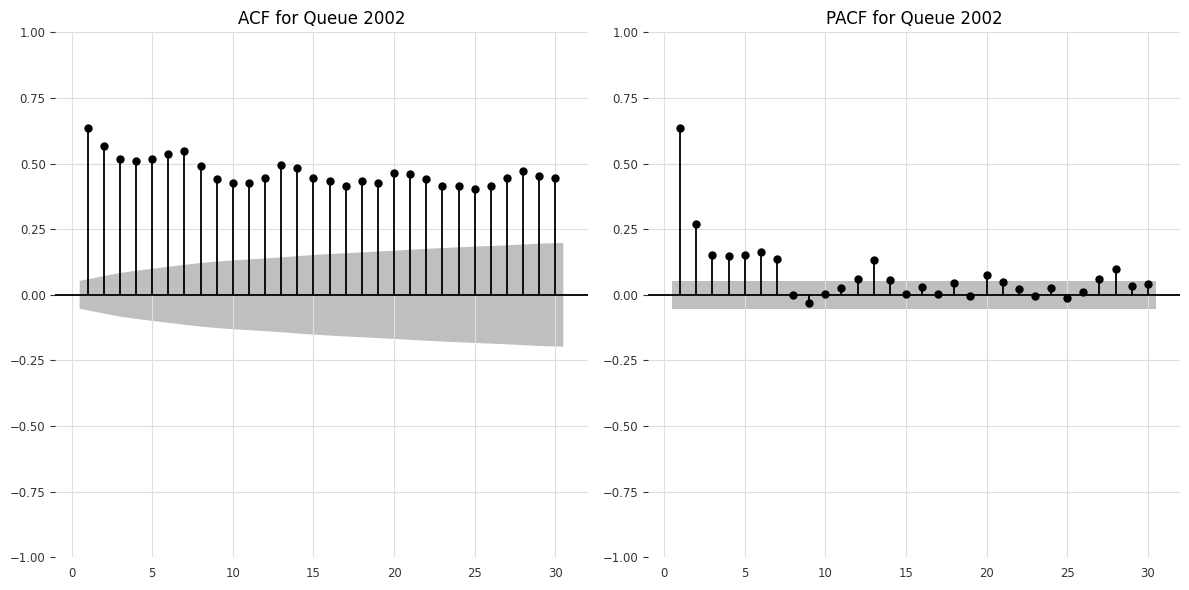

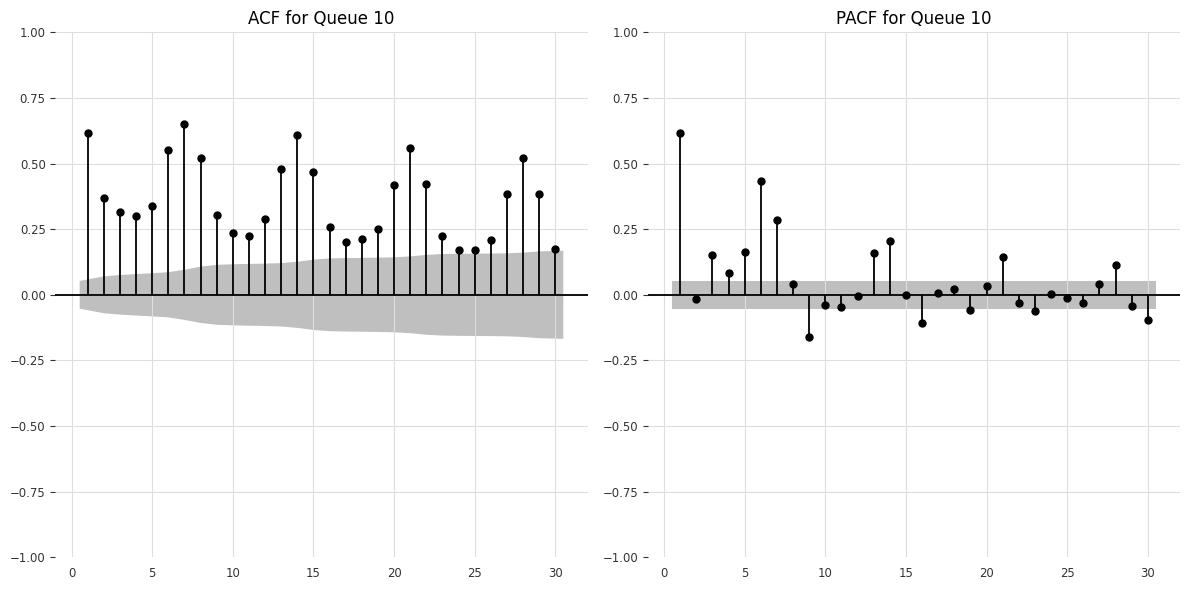

Queue ID 4412 does not exist in the dataset.


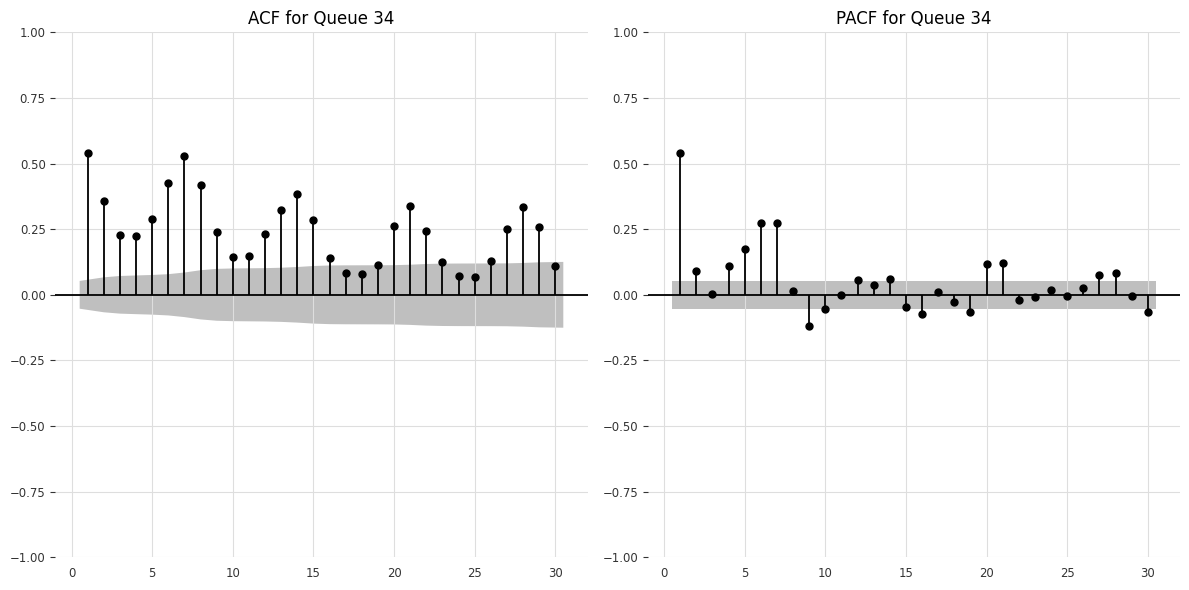

Queue ID 2610 does not exist in the dataset.
Queue ID: 1871
  ADF Statistic: -7.0993
  p-value: 0.0000
  Critical Values:
    1%: -3.4418
    5%: -2.8666
    10%: -2.5695

Queue ID: 115
  ADF Statistic: -3.4650
  p-value: 0.0089
  Critical Values:
    1%: -3.4352
    5%: -2.8637
    10%: -2.5679

Queue ID: 2002
  ADF Statistic: -2.7738
  p-value: 0.0621
  Critical Values:
    1%: -3.4352
    5%: -2.8637
    10%: -2.5679

Queue ID: 10
  ADF Statistic: -3.2966
  p-value: 0.0150
  Critical Values:
    1%: -3.4352
    5%: -2.8637
    10%: -2.5679

Queue ID: 34
  ADF Statistic: -4.3052
  p-value: 0.0004
  Critical Values:
    1%: -3.4352
    5%: -2.8637
    10%: -2.5679

{1871: {'ADF Statistic': -7.099273007087367, 'p-value': 4.209298560018473e-10, 'Critical Values': {'1%': -3.441834071558759, '5%': -2.8666061267054626, '10%': -2.569468095872659}}, 115: {'ADF Statistic': -3.46504601211487, 'p-value': 0.008931496667164356, 'Critical Values': {'1%': -3.435224876159216, '5%': -2.86369288129764

In [162]:
print(analyze_queues(df, top_queues))